# Rosenbrock banana

Here, we perform optimization for the Rosenbrock banana function, which does not require an AMICI model. In particular, we try several ways of specifying derivative information.

In [1]:
import pypesto
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

/home/yannik/yenv2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yannik/yenv2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Define the objective and problem

In [10]:
# first type of objective
objective1 = pypesto.Objective(fun=sp.optimize.rosen, 
                             grad=sp.optimize.rosen_der, 
                             hess=sp.optimize.rosen_hess)

# second type of objective
def rosen2(x):
    return sp.optimize.rosen(x), sp.optimize.rosen_der(x), sp.optimize.rosen_hess(x)
objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True)

dim_full = 10
lb = -2 * np.ones((dim_full, 1))
ub = 2 * np.ones((dim_full, 1))

problem1 = pypesto.Problem(objective=objective1, lb=lb, ub=ub)
problem2 = pypesto.Problem(objective=objective2, lb=lb, ub=ub)

(10, 1)
(1, 10)


## Illustration

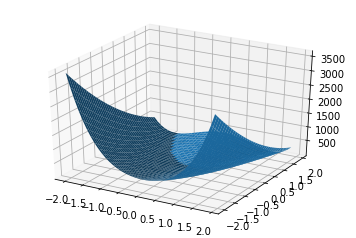

In [3]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j,k] = objective1([x[j,k], y[j,k]], (0,))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X=x, Y=y, Z=z)        

## Run optimization

In [4]:
optimizer = pypesto.ScipyOptimizer()
                                                                                                                                                                                                                                                                                                                                                                
result1 = pypesto.minimize(problem=problem1, optimizer=optimizer, n_starts=20)
result2 = pypesto.minimize(problem=problem2, optimizer=optimizer, n_starts=20)

/home/yannik/yenv2/lib/python3.6/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/home/yannik/yenv2/lib/python3.6/site-packages/scipy/optimize/_minimize.py:513: RuntimeWarning: Method L-BFGS-B does not use Hessian-vector product information (hessp).
  'information (hessp).' % method, RuntimeWarning)


## Visualize and analyze results

pypesto offers easy-to-use visualization routines:

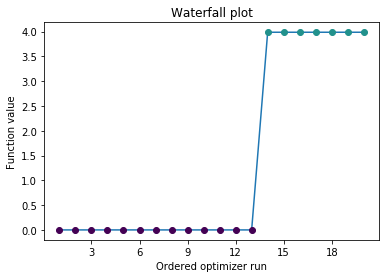

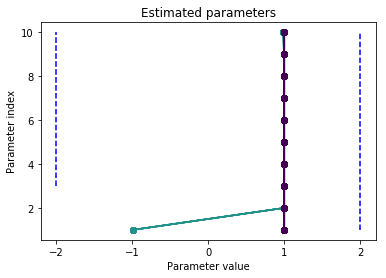

In [12]:
import pypesto.visualize

pypesto.visualize.waterfall(result1)
result1.problem.lb[0,1]=np.inf
pypesto.visualize.parameters(result1)

If the result needs to be examined in more detail, it can easily be exported as a pandas.DataFrame:

In [6]:
result1.optimize_result.as_dataframe(['fval', 'n_fval', 'time'])

,fval,n_fval,time
0,6.222400e-12,66,0.016133
1,7.196473e-12,73,0.046820
2,8.821794e-12,78,0.026949
3,1.417716e-11,78,0.043278
4,1.934362e-11,75,0.022871
5,2.544767e-11,63,0.016890
6,2.795380e-11,74,0.016368
7,3.248333e-11,92,0.022269
8,6.017529e-11,78,0.021816
9,7.889968e-11,85,0.019944
